### Obesity - Classification (Semester B)


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import magma
import matplotlib.cm as cm 
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')


np.set_printoptions(precision=7)

In [2]:
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
df.head(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight


בסמסטר הקודם הורדנו רק את עמודת המשקל מכיוון שייש לה קשר ישיר ל-בי-אמ-איי. בשיפור העבודה ננסה להוריד גם את עומדת הגובה שכן גם לה יש קשר חזק ל-בי-אמ-איי.
בסמסטר הקודם המודלים שלנו בעיקר התקשו להגדיר מהו אדם רגיל ומהו אדם עם אוביסטי סוג 3. 
ננסה להבין מה יוצר את הקושי וכימד נוכל לעזור למודלים שלנו לסווג בצורה טובה יותר.
בסמסטר הקודם, מדד הדיוק הגבוהה ביותר שהיה לנו הוא 81%. ננסה להשיג ציון טוב יותר או לפחות לנסות שמודלים שלנו לא יטעו בצורה קיצונית (כמו להגדיר אדם כאובוסטי סוג 3 כאשר בפועל הוא בתת משקל)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [4]:
#Other than 'Age', 'Weight' and 'Height' there is no reason for the other numeric columns to be 'float'. We'll change it.
columns = ["NCP", "CH2O", "TUE", "FAF","FCVC"]
for col in columns:
    df[col] = round(df[col]).astype('int')

In [5]:
df['family_history_with_overweight'] = df['family_history_with_overweight'].map({'no':0, 'yes':1})
df['CALC'] = df['CALC'].map({'no':0, 'Sometimes':1,'Frequently':2,'Always':3})

In [6]:
Insufficient_Weight = df.loc[df.NObeyesdad == "Insufficient_Weight"]
Obesity_Type_II = df.loc[df.NObeyesdad == "Obesity_Type_II"]
Obesity_Type_III = df.loc[df.NObeyesdad == "Obesity_Type_III"]

In [7]:
Type_III =Obesity_Type_III.describe(include='O').iloc[2:4]
Type_II =Obesity_Type_II.describe(include='O').iloc[2:4]
Insufficient_Weight_describe = Insufficient_Weight.describe(include='O').iloc[2:4]

In [8]:
pd.concat([Type_III, Type_II,Insufficient_Weight_describe],
          axis=0,keys=["Obesity_Type_III","Obesity_Type_II","Insufficient_Weight"])

Gender FAVC       CAEC SMOKE  SCC  \
Obesity_Type_III    top   Female  yes  Sometimes    no   no   
                    freq     323  323        323   323  324   
Obesity_Type_II     top     Male  yes  Sometimes    no   no   
                    freq     295  290        293   282  296   
Insufficient_Weight top   Female  yes  Sometimes    no   no   
                    freq     173  221        146   271  250   

                                         MTRANS           NObeyesdad  
Obesity_Type_III    top   Public_Transportation     Obesity_Type_III  
                    freq                    323                  324  
Obesity_Type_II     top   Public_Transportation      Obesity_Type_II  
                    freq                    200                  297  
Insufficient_Weight top   Public_Transportation  Insufficient_Weight  
                    freq                    220                  272

<AxesSubplot:xlabel='MTRANS', ylabel='Count'>

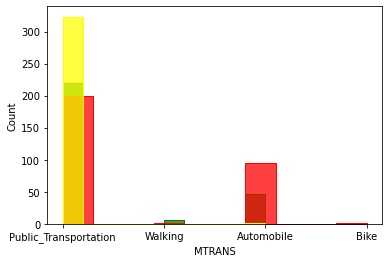

In [9]:
sns.histplot(data=Insufficient_Weight.MTRANS,color= "green",element="step",discrete = False)
sns.histplot(data=Obesity_Type_II.MTRANS,color="red",element="step",discrete = False)
sns.histplot(data=Obesity_Type_III.MTRANS,color="yellow",element="step",discrete = False)

In [10]:
df_res = df.copy(deep=True)
df_res = pd.get_dummies(df, columns=['Gender','FAVC','SMOKE',
                                     'SCC','MTRANS','FCVC','NCP','CAEC','CH2O','FAF','TUE'])
df_res.head(3)

,Age,Height,Weight,family_history_with_overweight,CALC,NObeyesdad,Gender_Female,Gender_Male,FAVC_no,FAVC_yes,...,CH2O_1,CH2O_2,CH2O_3,FAF_0,FAF_1,FAF_2,FAF_3,TUE_0,TUE_1,TUE_2
0,21.0,1.62,64.0,1,0,Normal_Weight,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
1,21.0,1.52,56.0,1,1,Normal_Weight,1,0,1,0,...,0,0,1,0,0,0,1,1,0,0
2,23.0,1.80,77.0,1,2,Normal_Weight,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0


In [11]:
df_res.drop(columns=['Weight'],inplace=True)

In [12]:
from sklearn.model_selection import train_test_split
X = df_res.drop(columns=["NObeyesdad"])
y = df_res['NObeyesdad'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler()
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

In [14]:
#split the train
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

##  Models:


* Random Forest
* XGBClassifier
* KNN

In [15]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_predict = dummy_clf.predict(X_val)
print("The DummyClassifier score is:" ,round(dummy_clf.score(y_predict,y_val),3))

The DummyClassifier score is: 0.157


In [16]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [17]:
# split the data to 10 folds
kf= KFold(n_splits=10, random_state=42, shuffle=True)

#### RandomForestClassifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = RF.predict(X_val)
norm_accuracy = round(metrics.accuracy_score(y_pred,y_val),3)
print("Accuracy:", norm_accuracy)

Accuracy: 0.828


In [25]:
from sklearn.ensemble import RandomForestClassifier

RForest = RandomForestClassifier(random_state=42)
random_forest= cross_val_score(RForest, X_train, y_train, cv=kf, scoring='accuracy').mean()
round(random_forest,3)

0.819

##### XGBClassifier

In [26]:
from xgboost import XGBClassifier

XGBClassifier = XGBClassifier(objective="binary:logistic", random_state=42,num_class=7,eval_metric='auc')
XGB = cross_val_score(XGBClassifier, X_train,y_train, cv=kf, scoring='accuracy').mean()
round(XGB,3)

0.819

In [29]:
from xgboost import XGBClassifier

XGBClassifier = XGBClassifier(objective="binary:logistic", random_state=42,num_class=7,eval_metric='auc')
XGBClassifier.fit(X_train,y_train)
y_pred = XGBClassifier.predict(X_val)
scores = accuracy_score(y_pred,y_val)
round(scores,3)

0.828

### RandomizedSearchCV:

In [30]:
#Searching for better performance out of the models with RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV

In [31]:
parameters = {'criterion':['gini','entropy'],
               'n_estimators': [int(x) for x in range(10, 400)],
               'max_depth':[int(x) for x in range(1, 20)]}
random_RF = RandomizedSearchCV(RandomForestClassifier(), parameters,verbose=True, n_jobs=-1,
                        cv=kf, random_state=42,n_iter=300,scoring='accuracy')
random_RF.fit(X_train,y_train)
y_pred_RF = random_RF.predict(X_val)
print(metrics.accuracy_score(y_val,y_pred_RF))
print (random_RF.best_params_)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
0.8284023668639053
{'n_estimators': 324, 'max_depth': 17, 'criterion': 'gini'}


In [40]:
#XGBClassifier
from xgboost import XGBClassifier

parameters = {
        'learning_rate': [ 0.1,0.3,0.03],
        'max_depth': [int(x) for x in range(1, 20)],
        'min_child_weight': [1, 2],
        'subsample': [0.5,0.6,1],
        'colsample_bytree': [0.3,0.5, 0.7],
        'n_estimators' : [100,150,170,200]
         }
XGBClassifier = XGBClassifier(objective="binary:logistic",num_class=7,eval_metric='auc')
random_XGB = RandomizedSearchCV(XGBClassifier,parameters, n_jobs=-1, 
                          cv = kf,random_state=42, n_iter = 50, verbose = True)
random_XGB.fit(X_train,y_train)
y_pred_XGB_random = random_XGB.predict(X_val)
print(round(metrics.accuracy_score(y_val,y_pred_XGB_random),3))
print (random_XGB.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
0.84
{'subsample': 1, 'n_estimators': 170, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


In [19]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



dt_clf = DecisionTreeClassifier()
log_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()
svm_clf = SVC(probability=True)
naive_clf = GaussianNB()
rnd_clf = RandomForestClassifier()

voting_clf = VotingClassifier(estimators=[('rnd',rnd_clf),('dt',dt_clf),('lr', log_clf), ('knn', knn_clf)
                                          , ('svc', svm_clf), ('nb', naive_clf)],voting='soft',n_jobs=-1,weights=[4,1,0,0,0,0])
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rnd', RandomForestClassifier()),
                             ('dt', DecisionTreeClassifier()),
                             ('lr', LogisticRegression()),
                             ('knn', KNeighborsClassifier()),
                             ('svc', SVC(probability=True)),
                             ('nb', GaussianNB())],
                 n_jobs=-1, voting='soft', weights=[4, 1, 0, 0, 0, 0])

In [20]:
for clf in (rnd_clf, dt_clf, log_clf, knn_clf, svm_clf, naive_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

RandomForestClassifier 0.8106508875739645
DecisionTreeClassifier 0.757396449704142
LogisticRegression 0.5857988165680473
KNeighborsClassifier 0.6390532544378699
SVC 0.6449704142011834
GaussianNB 0.3994082840236686
VotingClassifier 0.8165680473372781


In [50]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_val)

In [51]:
accuracy_score(y_val, y_pred)

0.7011834319526628

In [61]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True)

In [62]:
bag_clf.oob_score_

0.8296296296296296

In [63]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_val)
accuracy_score(y_val, y_pred)

0.834319526627219